# 1-3-1: 모델 Recall 검증

## 목적
API 수정 전에 모델 자체가 사기를 잡을 수 있는지 확인

## 판단 기준
| Recall | 판단 |
|--------|------|
| 70% 이상 | OK -> API만 수정 |
| 50~70% | 보통 -> API 수정 후 재평가 |
| 50% 미만 | 낮음 -> 모델 재학습 고려 |

In [7]:
# 패키지 임포트
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경로
DATA_PROCESSED = Path('../../data/processed')
MODELS_DIR = Path('../../models')

print("패키지 로드 완료!")

패키지 로드 완료!


---
## 1. 모델 및 데이터 로드

In [8]:
# 모델 로드
model_info = joblib.load(MODELS_DIR / 'xgb_model.joblib')
model = model_info['model']
saved_threshold = model_info.get('optimal_threshold', 0.5)

print(f"모델 로드 완료!")
print(f"저장된 threshold: {saved_threshold}")
print(f"저장된 Test AUC: {model_info.get('test_auc', 'N/A')}")

모델 로드 완료!
저장된 threshold: 0.184
저장된 Test AUC: 0.9114082025980027


In [9]:
# 테스트 데이터 로드
test_df = pd.read_csv(DATA_PROCESSED / 'test_features.csv')

X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

print(f"테스트 데이터: {X_test.shape}")
print(f"\n실제 사기 비율:")
print(f"  정상: {(y_test == 0).sum():,}건 ({(y_test == 0).mean()*100:.2f}%)")
print(f"  사기: {(y_test == 1).sum():,}건 ({(y_test == 1).mean()*100:.2f}%)")

테스트 데이터: (118108, 447)

실제 사기 비율:
  정상: 114,044건 (96.56%)
  사기: 4,064건 (3.44%)


---
## 2. 예측 확률 분포 확인

In [10]:
# 예측
y_prob = model.predict_proba(X_test)[:, 1]

print("전체 예측 확률 분포:")
print(f"  Min: {y_prob.min():.4f}")
print(f"  Max: {y_prob.max():.4f}")
print(f"  Mean: {y_prob.mean():.4f}")
print(f"  Median: {np.median(y_prob):.4f}")

전체 예측 확률 분포:
  Min: 0.0025
  Max: 0.9991
  Mean: 0.1813
  Median: 0.1127


In [11]:
# 실제 사기 케이스의 확률 분포
fraud_probs = y_prob[y_test == 1]
normal_probs = y_prob[y_test == 0]

print("실제 사기 케이스의 예측 확률:")
print(f"  Min: {fraud_probs.min():.4f}")
print(f"  Max: {fraud_probs.max():.4f}")
print(f"  Mean: {fraud_probs.mean():.4f}")
print(f"  Median: {np.median(fraud_probs):.4f}")

print("\n실제 정상 케이스의 예측 확률:")
print(f"  Min: {normal_probs.min():.4f}")
print(f"  Max: {normal_probs.max():.4f}")
print(f"  Mean: {normal_probs.mean():.4f}")
print(f"  Median: {np.median(normal_probs):.4f}")

실제 사기 케이스의 예측 확률:
  Min: 0.0186
  Max: 0.9991
  Mean: 0.6583
  Median: 0.7237

실제 정상 케이스의 예측 확률:
  Min: 0.0025
  Max: 0.9985
  Mean: 0.1643
  Median: 0.1080


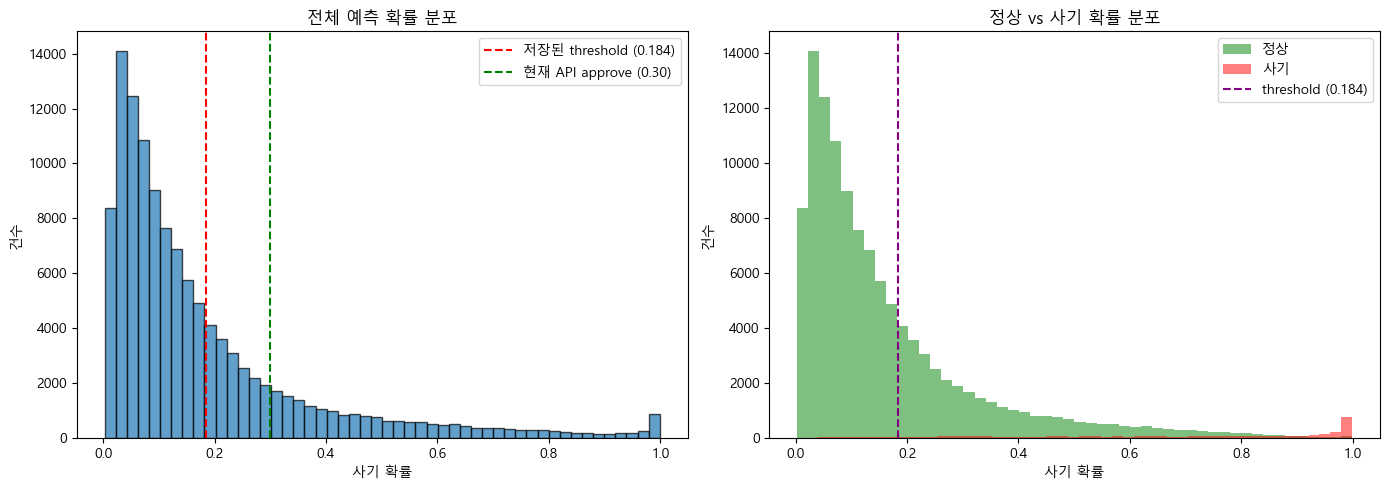

In [12]:
# 확률 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 전체 분포
axes[0].hist(y_prob, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=saved_threshold, color='r', linestyle='--', label=f'저장된 threshold ({saved_threshold})')
axes[0].axvline(x=0.30, color='g', linestyle='--', label='현재 API approve (0.30)')
axes[0].set_title('전체 예측 확률 분포')
axes[0].set_xlabel('사기 확률')
axes[0].set_ylabel('건수')
axes[0].legend()

# 사기 vs 정상 비교
axes[1].hist(normal_probs, bins=50, alpha=0.5, label='정상', color='green')
axes[1].hist(fraud_probs, bins=50, alpha=0.5, label='사기', color='red')
axes[1].axvline(x=saved_threshold, color='purple', linestyle='--', label=f'threshold ({saved_threshold})')
axes[1].set_title('정상 vs 사기 확률 분포')
axes[1].set_xlabel('사기 확률')
axes[1].set_ylabel('건수')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 3. Threshold별 Recall/Precision 측정

In [13]:
# 여러 threshold에서 성능 측정
thresholds = [0.05, 0.10, 0.15, 0.18, 0.20, 0.25, 0.30, 0.40, 0.50]

results = []
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    
    tp = ((y_pred == 1) & (y_test == 1)).sum()
    fp = ((y_pred == 1) & (y_test == 0)).sum()
    fn = ((y_pred == 0) & (y_test == 1)).sum()
    tn = ((y_pred == 0) & (y_test == 0)).sum()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'threshold': t,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Recall': recall,
        'Precision': precision,
        'F1': f1
    })

results_df = pd.DataFrame(results)
print("Threshold별 성능:")
print(results_df.to_string(index=False))

Threshold별 성능:
 threshold   TP    FP   FN     TN   Recall  Precision       F1
      0.05 4026 86527   38  27517 0.990650   0.044460 0.085101
      0.10 3909 60290  155  53754 0.961860   0.060889 0.114528
      0.15 3762 42644  302  71400 0.925689   0.081067 0.149079
      0.18 3686 34867  378  79177 0.906988   0.095609 0.172983
      0.20 3642 30712  422  83332 0.896161   0.106014 0.189599
      0.25 3509 22668  555  91376 0.863435   0.134049 0.232069
      0.30 3344 17403  720  96641 0.822835   0.161180 0.269558
      0.40 3069 10720  995 103324 0.755167   0.222569 0.343808
      0.50 2756  6666 1308 107378 0.678150   0.292507 0.408720


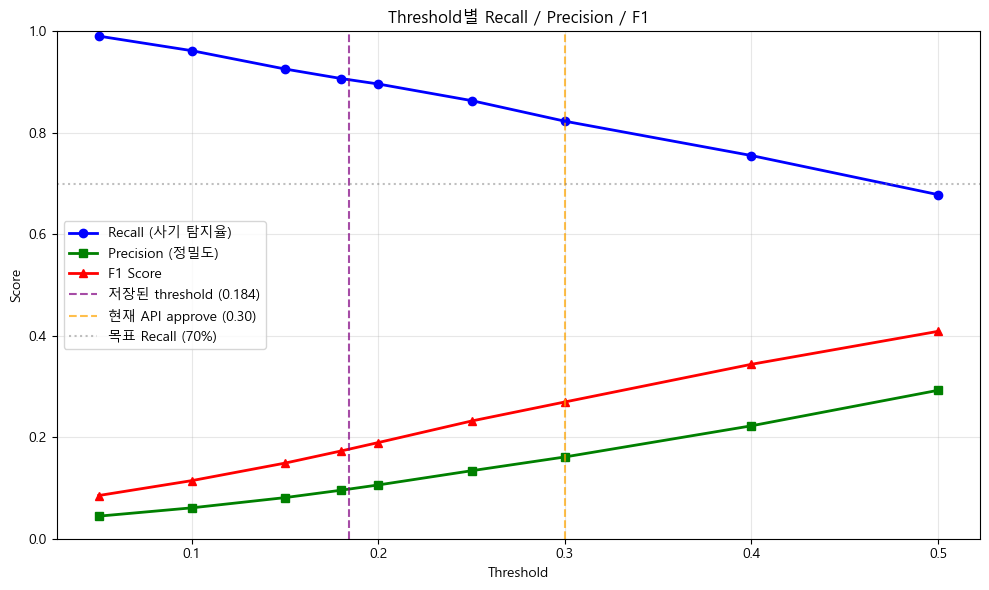

In [14]:
# Recall/Precision 시각화
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(results_df['threshold'], results_df['Recall'], 'b-o', label='Recall (사기 탐지율)', linewidth=2)
ax.plot(results_df['threshold'], results_df['Precision'], 'g-s', label='Precision (정밀도)', linewidth=2)
ax.plot(results_df['threshold'], results_df['F1'], 'r-^', label='F1 Score', linewidth=2)

ax.axvline(x=saved_threshold, color='purple', linestyle='--', alpha=0.7, label=f'저장된 threshold ({saved_threshold})')
ax.axvline(x=0.30, color='orange', linestyle='--', alpha=0.7, label='현재 API approve (0.30)')
ax.axhline(y=0.7, color='gray', linestyle=':', alpha=0.5, label='목표 Recall (70%)')

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold별 Recall / Precision / F1')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

---
## 3-1. AUC-ROC 및 AUPRC (현업 핵심 지표)

In [15]:
# AUC-ROC 계산
auc_roc = roc_auc_score(y_test, y_prob)

# AUPRC (PR-AUC) 계산 - 불균형 데이터에서 더 정확한 지표
auprc = average_precision_score(y_test, y_prob)

print("=" * 50)
print("핵심 지표")
print("=" * 50)
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUPRC (PR-AUC): {auprc:.4f}")
print()
print("현업 기준:")
print(f"  AUC-ROC: {'✅ 좋음' if auc_roc >= 0.90 else '⚠️ 보통' if auc_roc >= 0.85 else '❌ 낮음'} (기준: 0.90)")
print(f"  AUPRC: {'✅ 좋음' if auprc >= 0.5 else '⚠️ 보통' if auprc >= 0.3 else '❌ 낮음'} (기준: 0.50)")

핵심 지표
AUC-ROC: 0.9114
AUPRC (PR-AUC): 0.5313

현업 기준:
  AUC-ROC: ✅ 좋음 (기준: 0.90)
  AUPRC: ✅ 좋음 (기준: 0.50)


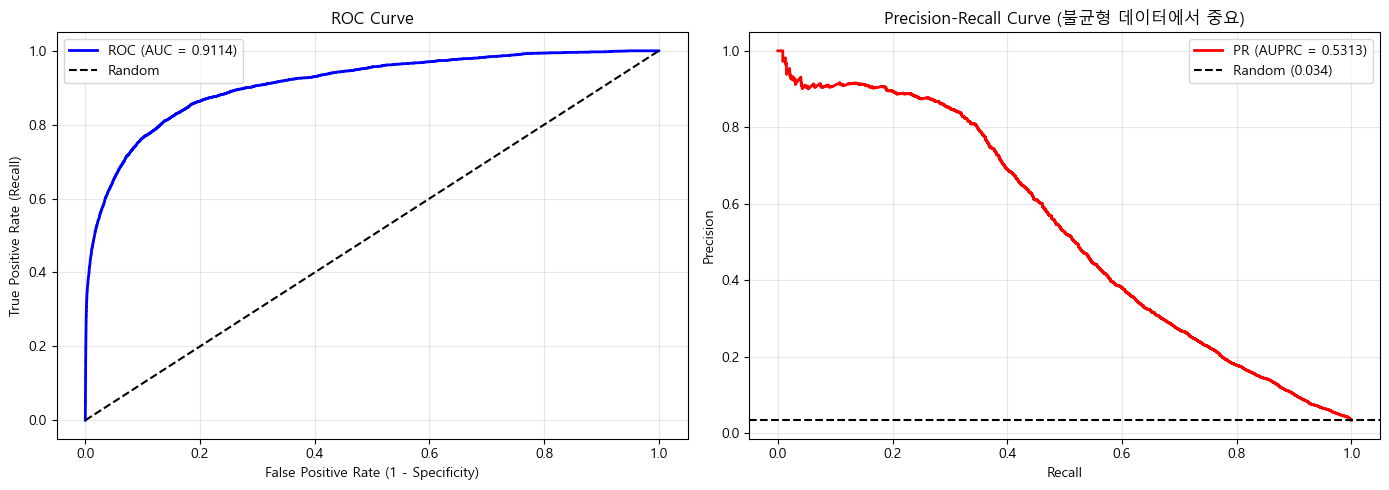


💡 불균형 데이터(3.5% 사기)에서는 PR 커브가 더 정확한 평가 지표


In [16]:
# ROC 커브 및 PR 커브 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC 커브
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {auc_roc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate (1 - Specificity)')
axes[0].set_ylabel('True Positive Rate (Recall)')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PR 커브 (불균형 데이터에서 더 중요)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
baseline = y_test.mean()  # 랜덤 기준선 = 사기 비율
axes[1].plot(recall_curve, precision_curve, 'r-', linewidth=2, label=f'PR (AUPRC = {auprc:.4f})')
axes[1].axhline(y=baseline, color='k', linestyle='--', label=f'Random ({baseline:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve (불균형 데이터에서 중요)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 불균형 데이터(3.5% 사기)에서는 PR 커브가 더 정확한 평가 지표")

---
## 4. 최적 Threshold에서 상세 성능

In [17]:
# 저장된 threshold 기준 성능
y_pred_optimal = (y_prob >= saved_threshold).astype(int)

print(f"=" * 50)
print(f"Threshold = {saved_threshold} 기준 성능")
print(f"=" * 50)
print()
print(classification_report(y_test, y_pred_optimal, target_names=['정상', '사기']))

Threshold = 0.184 기준 성능

              precision    recall  f1-score   support

          정상       1.00      0.70      0.82    114044
          사기       0.10      0.91      0.18      4064

    accuracy                           0.71    118108
   macro avg       0.55      0.80      0.50    118108
weighted avg       0.96      0.71      0.80    118108



In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)

print("Confusion Matrix:")
print(f"              예측 정상  예측 사기")
print(f"실제 정상      {cm[0,0]:>7,}   {cm[0,1]:>7,}  (FP: 오탐)")
print(f"실제 사기      {cm[1,0]:>7,}   {cm[1,1]:>7,}  (FN: 놓침)")
print()

recall = cm[1,1] / (cm[1,0] + cm[1,1])
precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0

print(f"Recall (사기 중 잡은 비율): {recall:.2%}")
print(f"Precision (사기라고 한 것 중 실제 사기): {precision:.2%}")
print(f"FN (놓친 사기): {cm[1,0]:,}건")
print(f"FP (오탐): {cm[0,1]:,}건")

Confusion Matrix:
              예측 정상  예측 사기
실제 정상       80,099    33,945  (FP: 오탐)
실제 사기          384     3,680  (FN: 놓침)

Recall (사기 중 잡은 비율): 90.55%
Precision (사기라고 한 것 중 실제 사기): 9.78%
FN (놓친 사기): 384건
FP (오탐): 33,945건


---
## 5. 결론

In [19]:
# 최종 판단
recall_at_optimal = results_df[results_df['threshold'] == saved_threshold]['Recall'].values
if len(recall_at_optimal) == 0:
    # 정확히 일치하는 threshold가 없으면 가장 가까운 값 사용
    y_pred_check = (y_prob >= saved_threshold).astype(int)
    recall_at_optimal = recall_score(y_test, y_pred_check)
else:
    recall_at_optimal = recall_at_optimal[0]

print("=" * 50)
print("최종 판단")
print("=" * 50)
print(f"\nThreshold {saved_threshold}에서 Recall: {recall_at_optimal:.2%}")
print()

if recall_at_optimal >= 0.7:
    print("결과: Recall 70% 이상")
    print("-> 모델 성능 OK. API만 수정하면 됨!")
elif recall_at_optimal >= 0.5:
    print("결과: Recall 50~70%")
    print("-> 보통. API 수정 후 재평가 필요")
else:
    print("결과: Recall 50% 미만")
    print("-> 모델 재학습 고려 필요!")

최종 판단

Threshold 0.184에서 Recall: 90.55%

결과: Recall 70% 이상
-> 모델 성능 OK. API만 수정하면 됨!
